### Imports

In [11]:
# Ajouter chemin système pour naviguer d'un dossier à l'autre facilement
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))

In [12]:
########## Imports ##########

import numpy as np
import pandas as pd
from packages import fonctions

# Représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import re
#from Levenshtein import *
import pickle
import os

from datetime import datetime
from time import time

# Outliers
from sklearn.ensemble import IsolationForest

# Import the tokenizer of NLTK
import nltk
# à télécharger une fois :
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import pairwise

import gensim.downloader as api
import gensim
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict
import multiprocessing
from gensim.models import Word2Vec

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Warnings
import warnings
warnings.simplefilter(action = 'ignore')

# Set display preferences
pd.set_option('display.max_row', 250)
pd.set_option('display.max_column', 100)

In [13]:
# Choix d'une palette de couleurs

sns.set_palette('Set2', color_codes = True)
print(sns.color_palette('Set2').as_hex())
# palettes testées : 'Spectral', 'flare', 'twilight', 'husl', 'Set1', 'Set2', 'Set3'
sns.set_style('darkgrid')
sns.color_palette()

['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']


[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [18]:
########## Import données csv ##########
# dossier data hors du dossier code pour ne pas l'importer dans github

df = pd.read_csv('../../data/flipkart_com-ecommerce_sample_1050.csv')
df.shape

(1050, 15)

In [19]:
df.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [21]:
########## Analyse du texte ##########

# librairies
# -> NLTK
# -> Spacy

# Regex cheatsheet -> https://www.debuggex.com/cheatsheet/regex/python

# recap cours
# token, retirer stopwords, stemming/lemmatization (supprimer suffixes et préfixes)

#### Category definition (target)

In [22]:
########## Extraire la catégorie de produit depuis la variable 'product_category_tree' ##########

In [23]:
# Dictionnaire des catégories (pour réduire le nombre de catégories - cf notebook Data_exploration_EDA)
dict_categories = {
    'Home and Kitchen Essential' : [
        'Home Furnishing', 'Tray Sets', 'Coffee Mugs', 'Lunch Boxes', 'Caffeine Bowls', 'Water bottle', 'Omic Sippers', 'Kitchen Tools', 'Bar Accessories', 'Bar Glasses', 'Idli Makers', 'Craft Jugs', 'Table Clocks', 'Bhalaria Forks', 'Kitchen Containers'],
    'Baby and Personal Care' : [
        'Baby Care', 'Personal Care'],
    'Electronics and Accessories' : [
        'Wrist Watches', 'Network Components', 'Tablet Accessories', 'Laptop Accessories', 'Pen Drives', 'Computer Components'],
    'Festive and Special Occasion' : ['Festive Needs', 'BFT Bulbs']
}

In [24]:
# Extraire catégories de la feature 'product_category_tree' et réduire nombre de catégories en utilisant le dictionnaire ci dessus
df['category'] = df.apply(fonctions.get_category, axis = 1)
inverse = { v: k for k, l in dict_categories.items() for v in l }
df['category_4'] = df['category'].map(inverse)
df['category_4'].value_counts()

category_4
Baby and Personal Care          300
Electronics and Accessories     292
Home and Kitchen Essential      263
Festive and Special Occasion    151
Name: count, dtype: int64

In [25]:
# ne garder que les deux colonnes qui nous intéressent : catégorie et description

df = df[['category_4', 'description']]
df.columns = ['category', 'description']
df.shape

(1050, 2)

In [26]:
df.sample(6)

,category,description
987,Festive and Special Occasion,Hand Art Terracotta Mask Showpiece - 28 cm (...
407,Electronics and Accessories,Buy TRENDnet N300 Wireless Home Router only fo...
318,Electronics and Accessories,Buy Asus Wireless AC2400 Dual-band Gigabit Rou...
642,Baby and Personal Care,Specifications of next steps Baby Girl's Strip...
844,Electronics and Accessories,Buy Task Logistics Audio Receiver H-366 USB Bl...
931,Home and Kitchen Essential,Buy Jaipur Textile Hub Floral Double Quilts & ...


#### Text pre processing

In [27]:
########## TEXT PROCESSING ##########

# utiliser la description des produits car texte le plus long
# explication à développer un peu

In [28]:
def nlp_preprocessing(df, colonne, langue):

    """
    Fonction pour faire le preprocessing de la colonne d'un df
    - tokenizer
    - enlever ponctuation
    - mettre en minuscule
    - enlever stop words
    - stem
    - lemmatize

    df -> nom du dataframe sur lequel on travaille
    colonne -> nom de la colonne qu'on veut transformer (str)
    langue -> nom anglais de la langue correspondante ('french', 'spanish', 'english'...) (str)

    return -> df avec une colonne 'tokens' en plus correspondant au texte preprocessé

    """
    # tokenizer
    df['tokens'] = df[colonne].apply(word_tokenize)

    # enlever ponctuation
    df['tokens'] = df['tokens'].apply(lambda x: [item for item in x if item.isalpha()])

    # mettre en minuscule
    df['tokens'] = df['tokens'].apply(lambda x : [item.lower() for item in x])

    # enlever stop words
    stop = stopwords.words(langue)
    df['tokens'] = df['tokens'].apply(lambda x: [item for item in x if item not in stop])

    # Stem
    stemmer = PorterStemmer()
    df['stemmed'] = df['tokens'].apply(lambda x: [stemmer.stem(item) for item in x])

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    df['lemmatized'] = df['stemmed'].apply(lambda x: [lemmatizer.lemmatize(item) for item in x])

    # Remove list format
    df['clean_text'] = df['lemmatized'].apply(lambda x: ' '.join(x))

    return df

In [29]:
nlp_preprocessing(df, 'description', 'english')

,category,description,tokens,stemmed,lemmatized,clean_text
0,Home and Kitchen Essential,Key Features of Elegance Polyester Multicolor ...,"[key, features, elegance, polyester, multicolo...","[key, featur, eleg, polyest, multicolor, abstr...","[key, featur, eleg, polyest, multicolor, abstr...",key featur eleg polyest multicolor abstract ey...
1,Baby and Personal Care,Specifications of Sathiyas Cotton Bath Towel (...,"[specifications, sathiyas, cotton, bath, towel...","[specif, sathiya, cotton, bath, towel, bath, t...","[specif, sathiya, cotton, bath, towel, bath, t...",specif sathiya cotton bath towel bath towel re...
2,Baby and Personal Care,Key Features of Eurospa Cotton Terry Face Towe...,"[key, features, eurospa, cotton, terry, face, ...","[key, featur, eurospa, cotton, terri, face, to...","[key, featur, eurospa, cotton, terri, face, to...",key featur eurospa cotton terri face towel set...
3,Home and Kitchen Essential,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[key, features, santosh, royal, fashion, cotto...","[key, featur, santosh, royal, fashion, cotton,...","[key, featur, santosh, royal, fashion, cotton,...",key featur santosh royal fashion cotton print ...
4,Home and Kitchen Essential,Key Features of Jaipur Print Cotton Floral Kin...,"[key, features, jaipur, print, cotton, floral,...","[key, featur, jaipur, print, cotton, floral, k...","[key, featur, jaipur, print, cotton, floral, k...",key featur jaipur print cotton floral king siz...
...,...,...,...,...,...,...
1045,Baby and Personal Care,Oren Empower Extra Large Self Adhesive Sticker...,"[oren, empower, extra, large, self, adhesive, ...","[oren, empow, extra, larg, self, adhes, sticke...","[oren, empow, extra, larg, self, adhes, sticke...",oren empow extra larg self adhes sticker pack ...
1046,Baby and Personal Care,Wallmantra Large Vinyl Sticker Sticker (Pack o...,"[wallmantra, large, vinyl, sticker, sticker, p...","[wallmantra, larg, vinyl, sticker, sticker, pa...","[wallmantra, larg, vinyl, sticker, sticker, pa...",wallmantra larg vinyl sticker sticker pack pri...
1047,Baby and Personal Care,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,"[buy, uberlyfe, extra, large, pigmented, polyv...","[buy, uberlyf, extra, larg, pigment, polyvinyl...","[buy, uberlyf, extra, larg, pigment, polyvinyl...",buy uberlyf extra larg pigment polyvinyl film ...
1048,Baby and Personal Care,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,"[buy, wallmantra, medium, vinyl, sticker, stic...","[buy, wallmantra, medium, vinyl, sticker, stic...","[buy, wallmantra, medium, vinyl, sticker, stic...",buy wallmantra medium vinyl sticker sticker on...


In [30]:
# regarder fonctions de cleaning proposées en exemple
# -> fonctions séparées (une fonction par action)

# --> faire pareil ? séparer étapes en fonctions différentes ?

In [31]:
# Maintenant que les features sont extraites -> réduction en 2 dimensions

In [33]:
# Encoding de la target

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['category'])

df['target_encoded'] = le.transform(df['category'])
df.head()

,category,description,tokens,stemmed,lemmatized,clean_text,target_encoded
0,Home and Kitchen Essential,Key Features of Elegance Polyester Multicolor ...,"[key, features, elegance, polyester, multicolo...","[key, featur, eleg, polyest, multicolor, abstr...","[key, featur, eleg, polyest, multicolor, abstr...",key featur eleg polyest multicolor abstract ey...,3
1,Baby and Personal Care,Specifications of Sathiyas Cotton Bath Towel (...,"[specifications, sathiyas, cotton, bath, towel...","[specif, sathiya, cotton, bath, towel, bath, t...","[specif, sathiya, cotton, bath, towel, bath, t...",specif sathiya cotton bath towel bath towel re...,0
2,Baby and Personal Care,Key Features of Eurospa Cotton Terry Face Towe...,"[key, features, eurospa, cotton, terry, face, ...","[key, featur, eurospa, cotton, terri, face, to...","[key, featur, eurospa, cotton, terri, face, to...",key featur eurospa cotton terri face towel set...,0
3,Home and Kitchen Essential,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[key, features, santosh, royal, fashion, cotto...","[key, featur, santosh, royal, fashion, cotton,...","[key, featur, santosh, royal, fashion, cotton,...",key featur santosh royal fashion cotton print ...,3
4,Home and Kitchen Essential,Key Features of Jaipur Print Cotton Floral Kin...,"[key, features, jaipur, print, cotton, floral,...","[key, featur, jaipur, print, cotton, floral, k...","[key, featur, jaipur, print, cotton, floral, k...",key featur jaipur print cotton floral king siz...,3


### Réduction de dimensions

In [34]:
df_pca = df[['target_encoded', 'clean_text']]

In [36]:
l_cat = list(set(df['category']))
print("catégories : ", l_cat)

catégories :  ['Home and Kitchen Essential', 'Baby and Personal Care', 'Electronics and Accessories', 'Festive and Special Occasion', nan]


In [38]:
y_cat_num = [(1-l_cat.index(df.iloc[i]['category'])) for i in range(len(df))]
y_cat_num

[1,
 0,
 0,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -2,
 1,
 -2,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 -1,
 1,
 0,
 1,
 -1,
 -3,
 -1,
 -1,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 -2,
 -2,
 0,
 0,
 -2,
 -2,
 -3,
 -3,
 1,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 0,
 0,
 0,
 -2,
 -2,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 -2,
 0,
 1,
 0,
 -3,
 -2,
 0,
 -2,
 -1,
 1,
 0,
 -1,
 -2,
 0,
 0,
 0,
 0,
 -2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -2,
 -2,
 -2,
 -2,
 1,
 -2,
 1,
 -2,
 -2,
 0,
 -2,
 1,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 1,
 1,
 -2,
 1,
 -2,
 0,
 -2,
 -2,
 1,
 -2,
 -2,
 -2,
 -2,
 

In [39]:
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des tweets par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des tweets par clusters')
    
    plt.show()
    print("ARI : ", ARI)

#### Bag of Words (BOW)

In [40]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'clean_text'
cv_fit = cvect.fit(df[feat])
ctf_fit = ctf.fit(df[feat])

cv_transform = cvect.transform(df[feat])  
ctf_transform = ctf.transform(df[feat])  

In [41]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)

CountVectorizer : 
-----------------
ARI :  0.2464 time :  5.0

Tf-idf : 
--------
ARI :  0.2978 time :  4.0


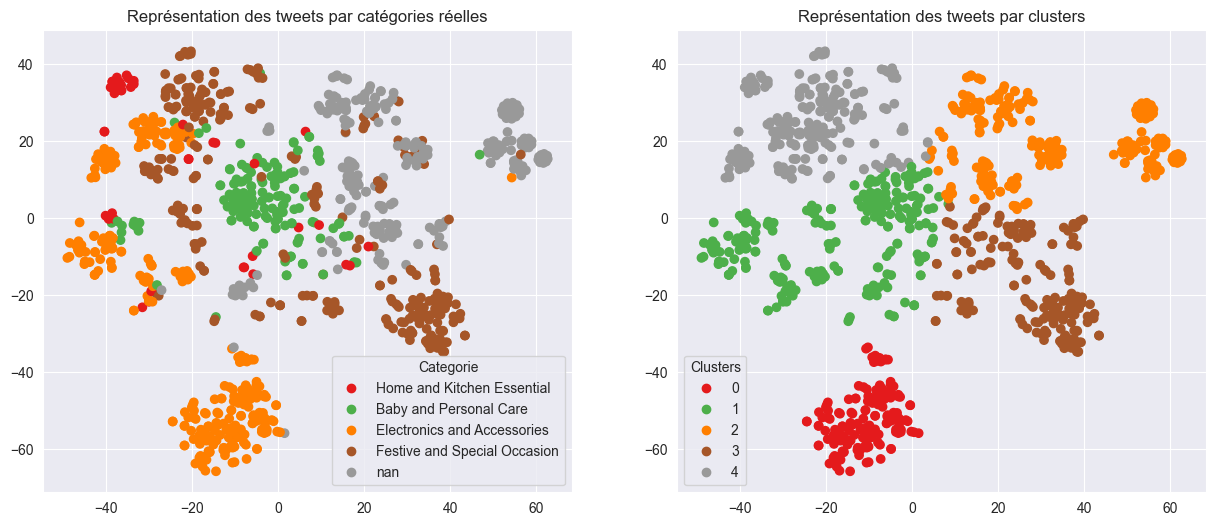

ARI :  0.2978


In [42]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [ ]:
########### BOW ##########
# = Bag of words
# -> vecteur qui garde l'information de combien de fois un mot est rencontré dans un texte donné

# Compute the BOW
BOWvectorizer = CountVectorizer(stop_words = 'english')
BOW = BOWvectorizer.fit_transform(df['clean_text']).toarray()

In [ ]:
BOWvectorizer.get_feature_names_out()

In [ ]:
#BOWvectorizer.get_feature_names() # -> ne fonctionne pas -> AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'
# dépend de la version de sklearn

In [ ]:
BOW = pd.DataFrame(data = BOW, columns = BOWvectorizer.get_feature_names_out())
BOW

In [ ]:
BOW.shape

In [ ]:
# Nombre de mots par ligne (donc pas description)
BOW.sum(axis = 1)

#### TF-IDF

In [ ]:
########### TF-IDF ###########
# Term Frequency (TF) = nb d'occurences d'un mot dans un texte normalisé par le nb de mots dans le texte - très proche du BOW, mais ici normalisation
# Inverse Document Frequency (IDF) = inverse de la fréquence d'un terme -> va donner un poids plus important à un mot rare qu'à un mot fréquent

# TF-IDF = TF x IDF

vectorizer = TfidfVectorizer(stop_words = 'english')
tf_idf = vectorizer.fit_transform(df['description_bow_lem']).toarray()
tf_idf

In [ ]:
#df_tfidf = pd.DataFrame(data = tf_idf, columns = vectorizer.get_feature_names())
df_tfidf = pd.DataFrame(data = tf_idf, columns = vectorizer.get_feature_names_out()) # attention, dépend de la version de sklearn utilisée
df_tfidf

In [ ]:
df_tfidf.shape

In [ ]:
########## Similarité ##########
# similarité entre deux textes

# cosine similarity = produit scalaire entre deux vecteurs
pairwise.cosine_similarity(tf_idf)

In [ ]:
plt.figure(figsize = (15, 15))
plt.imshow(pairwise.cosine_similarity(tf_idf))
plt.show()

In [ ]:
# définir un seuil de similarité ?

plt.figure(figsize = (15, 15))
plt.imshow(pairwise.cosine_similarity(tf_idf) > 0.2)
plt.show()


### Word embedding

In [ ]:
########## Word embedding #########

# représentation matricielle, chaque mot à un nb donné de features
# idée de relation entre les mots
# but = pouvoir prédire le mot suivant dans une phrase

# GloVe, Word2Vec...

# A Word Embedding is a matrix representation, meaning each word has a given number of features. You can see the words as vectors and the features as their coordinates.
# There are many different Word Embeddings

#### GloVe

In [ ]:
########## GloVe ##########
# = Global Vector
# unsupervised learning algorithm for obtaining vector representations for words

# made by Stanford NLP group -> https://nlp.stanford.edu/projects/glove/
# light word embedding, but still powerful
# several models exit, to encode words into vectors of 50, 100, 200 or even 300 dimensions


In [ ]:
texts = df['description_bow_lem']
target = df["category"]

In [ ]:
# Calculate the length of our vocabulary
from keras.preprocessing.text import Tokenizer
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

In [ ]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('../data/glove.6B/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype = 'float32')
        embeddings_dictionary [word] = vector_dimensions

# embeddings_dictionary

In [ ]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

In [ ]:
print(embedding_matrix.shape)
pca = decomposition.PCA(n_components = 0.99)
feat_pca = pca.fit_transform(embedding_matrix)
print(feat_pca.shape)

from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components = 2, perplexity = 30, n_iter = 2000, init = 'random', random_state = 6)
X_tsne = tsne.fit_transform(feat_pca)

duration1 = time.time() - temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

df_tsne = pd.DataFrame(X_tsne, columns = ['tsne1', 'tsne2'])
df_tsne["class"] = df["category"]

plt.figure(figsize = (8,5))
sns.scatterplot(
    x = "tsne1", y = "tsne2",
    hue = "class",
    palette = sns.color_palette('tab10', n_colors = 4), s = 50, alpha = 0.6,
    data = df_tsne,
    legend = "brief")

plt.title('TSNE avec GloVe', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop = {'size': 14}) 

plt.show()

In [ ]:
# nuuuuul

#### Word2Vec

In [ ]:
########## Word2Vec ##########
# -> le word embedding le plus utilisé à l'heure actuelle - puissant et versatile
# pretrained model by Google
# https://code.google.com/archive/p/word2vec/
# This model is particularly complex, thus the pretrained model is saved in a very large file (about 4 GB)

# Load Google's pre-trained Word2Vec model, give the right path to the downloaded file
model = gensim.models.KeyedVectors.load_word2vec_format('../data/GoogleNews-vectors-negative300.bin', binary = True)
model

In [ ]:
df['description_bow_lem'][0]

In [ ]:
# tutoriel sur kaggle -> https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial
sent = [row.split() for row in df['description_bow_lem']]
phrases = Phrases(sent, min_count = 30, progress_per = 10000)

In [ ]:
bigram = Phraser(phrases)
bigram

In [ ]:
sentences = bigram[sent]
sentences

In [ ]:
sentences[0]

In [ ]:
# Most frequent words
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

In [ ]:
word_freq

In [ ]:
sorted(word_freq, key = word_freq.get, reverse = True)[:10]

In [ ]:
cores = multiprocessing.cpu_count()

In [ ]:
w2v_model = Word2Vec(
    min_count = 20,
    window = 2,
    sample = 6e-5,
    alpha = 0.03,
    min_alpha = 0.0007,
    negative = 20,
    workers = cores-1
    )

# to do -> explorer les paramètres

In [ ]:
t = time()

w2v_model.build_vocab(sentences, progress_per = 10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
t = time()

w2v_model.train(sentences, total_examples = w2v_model.corpus_count, epochs = 30, report_delay = 1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
w2v_model.init_sims(replace = True)

In [ ]:
w2v_model.wv.most_similar(positive = ['color'])

In [ ]:
w2v_model.wv.most_similar(positive = ['buy'])

In [ ]:
w2v_model.wv.most_similar(positive = ['watch'])

In [ ]:
w2v_model.wv.similarity('buy', 'watch')

In [ ]:
w2v_model.wv.doesnt_match(['buy', 'color', 'carpet'])

In [ ]:
w2v_model.wv.doesnt_match(['watch', 'bracelet', 'carpet'])

In [ ]:
#tsnescatterplot(w2v_model, 'watch', ['carpet', 'buy', 'feature', 'machine', 'gold', 'table', 'clock', 'green'])
# PROBLEME ICI
# ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 300 and the array at index 1 has size 100

# à creuser

#### FastText

In [ ]:
########## FastText ##########

# developed by Facebook AI Research lab
# probably the most efficient Word Embedding
# does not only use words, but all possible n-grams (at character level) of any word to compute its embedding
# far more complex and heavy to use than the other models
# https://fasttext.cc/#

In [ ]:
! pip install fasttext

In [ ]:
# meh...

#### Latent Dirichlet Allocation (LDA)

In [ ]:
########## LDA ########### 

# Le modèle Latent Dirichlet Allocation suppose que chaque document est un mélange d’un petit nombre de topics, et que chaque occurrence d’un mot correspond à l’un des sujets du document. 
# En réalité, chaque mot se voit attribuer un topic selon la loi de Dirichlet. On obtient donc un premier topic model. Pour générer le suivant, on prend chaque mot et on met à jour le topic auquel il est associé. 
# Ce nouveau thème est celui qui aurait la plus forte probabilité de le générer dans ce document.
# Le Latent Dirichlet Allocation n’est pas un algorithme à itération unique. A la première itération, l’algorithme attribue au hasard des mots aux topics. 
# Il passe ensuite en revue chaque mot de chaque document et applique des formules de calcul de probabilité.
# Le processus est ensuite répété à travers diverses itérations jusqu’à ce que l’algorithme génère un ensemble de topics et qu’on obtiennent un modèle satisfaisant.

In [ ]:
# https://larevueia.fr/latent-dirichlet-allocation-topic-modeling-en-python/
# cours vivadata:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.models import LsiModel
from pprint import pprint
from gensim.models import LdaModel

In [ ]:
# Create a corpus
corpus = df['tokens']

# Compute the dictionary: this is a dictionary mapping words and their corresponding numbers for later visualisation
id2word = Dictionary(corpus)

# Create a BOW
bow = [id2word.doc2bow(line) for line in corpus]  # convert corpus to BoW format

# Instanciate a TF-IDF
tfidf_model = TfidfModel(bow)

# Compute the TF-IDF
tf_idf_gensim = tfidf_model[bow]

In [ ]:
# Compute the LDA
lda1 = LdaModel(corpus = tf_idf_gensim, num_topics = 5, id2word = id2word, passes = 10, random_state = 0)

# Print the main topics
pprint(lda1.print_topics())

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
pd.set_option('display.max_columns', 500) 

# Instantiate the TF-IDF vectorizer
vectorizer = TfidfVectorizer(lowercase = False, analyzer = lambda x: x)

# Compute the TF-IDF
tf_idf = vectorizer.fit_transform(df['tokens'])
pd.DataFrame(data = tf_idf.toarray(), columns = vectorizer.get_feature_names_out(), index = corpus.index).head()


In [ ]:
# Dictionary mapping from word IDs to words, initialized in a lazy manner to save memory (not created until needed)
dictionary = Dictionary(df['tokens'])
print(dictionary)

In [ ]:
from gensim.matutils import Sparse2Corpus
from pprint import pprint

# Convert the TF-IDF to the needed input for Gensim
tf_idf_sklearn = Sparse2Corpus(tf_idf, documents_columns = False)

In [ ]:
# Compute the LDA
lda2 = LdaModel(corpus = tf_idf_sklearn, id2word = id2word, num_topics = 5, passes = 10, random_state = 42)

# Print the main topics
pprint(lda2.print_topics())

In [ ]:
pip install pyLDAvis==2.1.2

In [ ]:
# LDA visualization

# Import the modules
import pyLDAvis
from pyLDAvis import gensim

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model = lda1, corpus = bow, dictionary = id2word)
vis

In [ ]:
# Trouver comment visualiser avec fond blanc sinon on voit rien

In [ ]:
#(cf cours openclassrooms)
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 20

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components = n_topics,
        max_iter = 5,
        learning_method = 'online',
        learning_offset = 50.,
        random_state = 0
        )

# Fitter sur les données
lda.fit(df['description_dl'])

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)


In [ ]:
########## NMF ########### (cf cours openclassrooms)
# NMF = Negative Matrix Factorisation
# = modélisation de sujet automatique non supervisée

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(
    max_df = 0.95, 
    min_df = 2, 
    max_features = no_features, 
    stop_words = 'english'
    )
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

no_topics = 20

# Run NMF
nmf = NMF(n_components = no_topics, random_state = 1, alpha = .1, l1_ratio = .5, init = 'nndsvd')
nmf.fit(tfidf)

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)


#### BERT

In [ ]:
########## BERT ###########

# Liens ressources Openclassrooms :
# https://huggingface.co/docs/transformers/index
# https://github.com/google-research/bert
# https://lesdieuxducode.com/blog/2019/4/bert--le-transformer-model-qui-sentraine-et-qui-represente
# https://huggingface.co/docs/transformers/model_doc/bert#transformers.TFBertModel
# https://www.kaggle.com/models/tensorflow/bert/frameworks/tensorFlow2/variations/en-uncased-l-12-h-768-a-12/versions/4?tfhub-redirect=true

# tutoriel
# https://www.kaggle.com/code/harshjain123/bert-for-everyone-tutorial-implementation

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

#### specify GPU
# cuda = parallel computing platform by NVIDIA, for efficient GPU acceleration
# si mal installé -> erreurs ensuite
device = torch.device("cuda")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.cuda.is_available())
print(torch.cuda.device_count())

In [ ]:
df

In [ ]:
df.columns

In [ ]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['description_dl'], df['category'], random_state = 2018, test_size = 0.3)

In [ ]:
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state = 2018, test_size = 0.5)

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

except:
    strategy = tf.distribute.get_strategy()

print('Number of replicas in sync: ', strategy.num_replicas_in_sync)

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens = True,
            max_length = maximum_length,
            pad_to_max_length = True,

            return_attention_mask = True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids), np.array(attention_masks)

In [ ]:
texts = df['description_dl']
target = df['category']

train_input_ids, train_attention_masks = bert_encode(texts, 60)

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape = (60,), dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (60,), dtype = 'int32')

    output = bert_model([input_ids, attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32, activation = 'relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation = 'sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)
    model.compile(Adam(lr = 1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

In [ ]:
model = create_model(bert_model)
model.summary()

In [ ]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split = 0.2,
    epochs = 3,
    batch_size = 10
)

In [ ]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize = (20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]], fontsize = 18)
        ax[idx].set_xlabel('A',fontsize = 16)
        ax[idx].set_ylabel('B',fontsize = 16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1], fontsize = 16)

In [ ]:
plot_learning_curves(history, [['loss', 'val_loss'], ['accuracy', 'val_accuracy']])

In [ ]:
# faire predict

In [ ]:
print(embedding_matrix.shape)
pca = decomposition.PCA(n_components = 0.99)
feat_pca = pca.fit_transform(embedding_matrix)
print(feat_pca.shape)

from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components = 2, perplexity = 30, n_iter = 2000, init = 'random', random_state = 6)
X_tsne = tsne.fit_transform(feat_pca)

duration1 = time.time() - temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

df_tsne = pd.DataFrame(X_tsne, columns = ['tsne1', 'tsne2'])
df_tsne["class"] = df["category"]

plt.figure(figsize = (8,5))
sns.scatterplot(
    x = "tsne1", y = "tsne2",
    hue = "class",
    palette = sns.color_palette('tab10', n_colors = 4), s = 50, alpha = 0.6,
    data = df_tsne,
    legend = "brief")

plt.title('TSNE avec GloVe', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop = {'size': 14}) 

plt.show()

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length = True,
    truncation = True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length = True,
    truncation = True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length = True,
    truncation = True
)

In [ ]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
# https://stackoverflow.com/questions/65804689/with-bert-text-classification-valueerror-too-many-dimensions-str-error-occur
# The issue is you are passing a list of strings (str) in torch.tensor() , it only accepts the list of numerical values (integer, float etc.)
# -> solution : convertir les labels en int (dictionnaire)

df['category'].unique()

In [ ]:
category_mapping = {
    'Home and Kitchen Essential' : 0,
    'Baby and Personal Care' : 1,
    'Electronics and Accessories' : 2,
    'Festive and Special Occasion' : 3,
    'Other' : 4
    }

df['category_num'] = df['category'].map(category_mapping)
df['category_num']

In [ ]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['description_dl'], df['category_num'], random_state = 2018, test_size = 0.3)
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state = 2018, test_size = 0.5)

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length = True,
    truncation = True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length = True,
    truncation = True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length = True,
    truncation = True
)

In [ ]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, 2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim = 1)

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)
print("Class Weights:", class_weights)

In [ ]:
df['category_num'].unique()

In [ ]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = df['category_num'].unique(), y = train_labels)
print("Class Weights:", class_weights)

In [ ]:
# séparation train/test -> certains labels se sont retrouvés exclusivement dans train ou dans test

In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights, dtype = torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight = weights) 

# number of training epochs
epochs = 10

In [ ]:
# function to train the model
def train():
    
    model.train()
    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds = []
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis = 0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

#### Universal Sentence Encoder (USE)

In [ ]:
########## USE (Universal Sentence Encoder) ##########

# https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder?hl=fr

from absl import logging

import tensorflow as tf
!pip install tensorflow_hub
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

In [ ]:
# Universal Sentence Encoder encodes entire sentence or text into vectors of real numbers that can be used for clustering, sentence similarity, text classification, 
# and other Natural language processing (NLP) tasks.
# The pre-trained model is trained on greater than word length text, sentences, phrases, paragraphs, etc using a deep averaging network (DAN) encoder.

# word embedding -> represent word into vectors
# sentence embedding -> entire sentence or text along with semantics information is mapped into vectors of real numbers

In [ ]:
# test avec les exemples donnés

word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

In [ ]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

In [ ]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

run_and_plot(messages)

In [ ]:
run_and_plot(df['description_dl'])

In [ ]:
# test avec mon jeu de données
# https://www.geeksforgeeks.org/word-embedding-using-universal-sentence-encoder-in-python/

sentences = df['description_dl']

embeddings = embed(sentences)

# Printing embeddings of each sentence
print(embeddings) 
  
# To print each embeddings along with its corresponding sentence below code can be used.
for i in range(len(sentences)): 
    print(sentences[i]) 
    print(embeddings[i])

In [ ]:
#Explanation:
#The above output represents input sentences into their corresponding vectors using the Universal Sentence encoder.

### Comparaison

In [ ]:
# A faire -> comparer la performance des différentes approches (avec/sans bow/tfidf, avec/sans word embedding et comparer les 3 word embedding differents)

In [ ]:
########## CONCLUSION ##########

# -> à dire en ouverture
# analyse de texte basée sur description des produits semble pertinente car blablabla
# cependant, repose sur description -> il faut donc avec une description relativement pertinente du produit déjà disponible pour pouvoir le classifier automatiquement - pas super pratique